<a href="https://colab.research.google.com/github/mjgpinheiro/AI-Strategies-StockMarket/blob/main/Metropolis_Pred_Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed


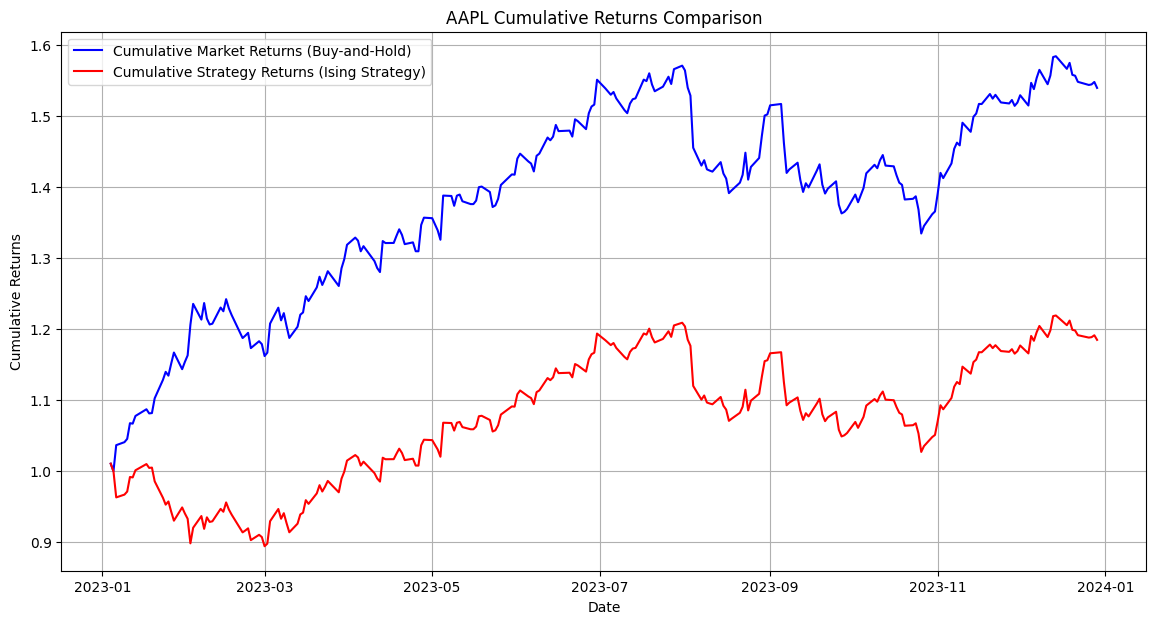

ROI of Ising Model Strategy: 18.46%
ROI of Buy-and-Hold: 53.94%


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Fetch AAPL stock data
def fetch_stock_data(symbol, start_date, end_date):
    data = yf.download(symbol, start=start_date, end=end_date)
    return data

# Initialize a lattice with random spins
def initialize_lattice(N):
    return np.random.choice([-1, 1], size=(N, N))

# Metropolis algorithm for one step
def metropolis_step(lattice, T, J, h):
    N = lattice.shape[0]
    for _ in range(N**2):
        x, y = np.random.randint(0, N), np.random.randint(0, N)
        current_spin = lattice[x, y]
        neighbor_sum = (lattice[(x+1)%N, y] + lattice[x, (y+1)%N] +
                        lattice[(x-1)%N, y] + lattice[x, (y-1)%N])
        delta_E = 2 * current_spin * (J * neighbor_sum + h)
        if delta_E < 0 or np.random.random() < np.exp(-delta_E / T):
            lattice[x, y] = -current_spin
    return lattice

# Simulate Ising model and calculate net magnetization
def simulate_ising(N, T, J, h, steps):
    lattice = initialize_lattice(N)
    magnetizations = []
    for _ in range(steps):
        lattice = metropolis_step(lattice, T, J, h)
        magnetization = np.sum(lattice)
        magnetizations.append(magnetization)
    return magnetizations

# Generate buy/sell signals based on magnetization trend
def generate_signals(magnetizations):
    signals = []
    for m in magnetizations:
        if m > 0:
            signals.append(1)  # Buy signal
        elif m < 0:
            signals.append(-1)  # Sell signal
        else:
            signals.append(0)  # Hold
    return signals

# Backtest the trading strategy with real stock data
def backtest_strategy(data, signals):
    data['Returns'] = data['Close'].pct_change()
    data['Signal'] = signals[:len(data)]  # Align signals with data length
    data['Signal'] = data['Signal'].fillna(0)  # Fill any NaN values with 0 (Hold)
    data['Strategy Returns'] = data['Returns'] * data['Signal'].shift(1)  # Align signals by shifting

    # Calculate cumulative returns
    data['Cumulative Market Returns'] = (1 + data['Returns']).cumprod()
    data['Cumulative Strategy Returns'] = (1 + data['Strategy Returns']).cumprod()

    # Display the final cumulative returns
    final_cumulative_strategy = data['Cumulative Strategy Returns'].iloc[-1]
    final_cumulative_market = data['Cumulative Market Returns'].iloc[-1]

    return data, final_cumulative_strategy, final_cumulative_market

# Parameters for Ising model and stock data
symbol = 'AAPL'
start_date = '2023-01-01'
end_date = '2023-12-31'
N = 50  # lattice size
T = 2.5  # temperature
J = 1.0  # interaction strength
h = 0.01  # external magnetic field (sentiment impact)
steps = 250  # number of Ising model steps

# Fetch stock data
data = fetch_stock_data(symbol, start_date, end_date)

# Simulate market sentiment using the Ising model
magnetizations = simulate_ising(N, T, J, h, steps)

# Generate buy/sell signals based on the simulated magnetization
signals = generate_signals(magnetizations)

# Backtest strategy and calculate cumulative returns
data, final_cumulative_strategy, final_cumulative_market = backtest_strategy(data, signals)

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(data['Cumulative Market Returns'], label='Cumulative Market Returns (Buy-and-Hold)', color='blue')
plt.plot(data['Cumulative Strategy Returns'], label='Cumulative Strategy Returns (Ising Strategy)', color='red')
plt.title(f'{symbol} Cumulative Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

# Print final ROI
roi_strategy = (final_cumulative_strategy - 1) * 100  # Convert to percentage
roi_market = (final_cumulative_market - 1) * 100  # Convert to percentage
print(f"ROI of Ising Model Strategy: {roi_strategy:.2f}%")
print(f"ROI of Buy-and-Hold: {roi_market:.2f}%")
